#**Fraud Detection Model**

### **Project Overview**

Fraud detection is a critical challenge in modern digital payment systems, where high transaction volumes and multiple access channels create opportunities for fraudulent activity to occur alongside legitimate behavior. This exploratory data analysis (EDA) focuses on understanding transaction-level patterns and risk indicators that may help distinguish fraudulent transactions from non-fraudulent ones.

The dataset contains detailed transactional, behavioral, and risk-related attributes, including transaction metadata, monetary values, customer profile information and device and network signals. The target variable, is_fraud, indicates whether a transaction has been identified as fraudulent.

The goal of this EDA is to explore the distribution, relationships, and interactions among these features to uncover patterns associated with fraudulent behavior. Specifically, the analysis examines how fraud prevalence varies across transaction channels, currencies, geographic attributes, device usage, customer tenure, and transaction velocity. Particular attention is paid to behavioral signals such as rapid transaction frequency, low device trust scores, high-risk IPs, and inconsistencies between user location and transaction origin, as these are commonly associated with fraud

In [1]:
#Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn

In [4]:
# Read the data
from google.colab import files
uploaded = files.upload()

Saving nova_pay_transcations.csv to nova_pay_transcations (1).csv


In [5]:
nova_pay = pd.read_csv('nova_pay_transcations.csv')

In [6]:
nova_pay.head()

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,US,USD,CAD,ATM,278.19,278.19,4.25,...,0.123,Standard,263,0.522,0,0.223,0,0,0.0,0
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.468549+00:00,CA,CAD,MXN,web,208.51,154.29,4.24,...,0.569,Standard,947,0.475,0,0.268,0,1,0.0,0
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-03 23:02:43.468549+00:00,US,USD,CNY,Mobile,160.33,160.33,2.70,...,0.437,Standard,367,0.939,0,0.176,0,0,0.0,0
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,2022-10-04 01:08:53.468549+00:00,US,USD,EUR,Mobile,59.41,59.41,2.22,...,0.594,Standard,147,0.551,0,0.391,0,0,0.0,0
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,2022-10-04 09:35:03.468549+00:00,US,USD,INR,Mobile,200.96,200.96,3.61,...,0.121,Enhanced,257,0.894,0,0.257,0,0,0.0,0


###**Data Overview**

In [7]:
nova_pay.shape

(10200, 26)

In [8]:
nova_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             10200 non-null  object 
 1   customer_id                10200 non-null  object 
 2   timestamp                  10171 non-null  object 
 3   home_country               10200 non-null  object 
 4   source_currency            10200 non-null  object 
 5   dest_currency              10200 non-null  object 
 6   channel                    10200 non-null  object 
 7   amount_src                 10200 non-null  object 
 8   amount_usd                 9895 non-null   float64
 9   fee                        9905 non-null   float64
 10  exchange_rate_src_to_dest  10200 non-null  float64
 11  device_id                  10200 non-null  object 
 12  new_device                 10200 non-null  bool   
 13  ip_address                 9895 non-null   obj

In [9]:
nova_pay.describe(include ='object')

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,device_id,ip_address,ip_country,kyc_tier
count,10200,10200,10171,10200,10200,10200,10200,10200,10200,9895,9899,10200
unique,10000,115,9941,7,3,9,6,8795,913,9700,9,4
top,3c8d7084-fba8-4ae0-950a-95f6b6e97e46,402cccc9-28de-45b3-9af7-cc5302aa1f93,0000-00-00T00:00:00Z,US,USD,USD,Mobile,102.29,e70db499-19e1-4927-b04f-3ebfcf62e33c,7.40.193.68,US,Standard
freq,2,1510,21,7287,7378,1253,6063,5,87,2,6402,7609


## **Data Preparation**

In [10]:
#Fix the data type
nova_pay['timestamp'] = pd.to_datetime(nova_pay['timestamp'], errors='coerce')

In [11]:
nova_pay['channel'] = nova_pay['channel'].str.lower().str.strip()
nova_pay['channel'] = nova_pay['channel'].replace({
    'atm': 'ATM',
    'mobile': 'Mobile',
    'web': 'Web',
    'unknown': 'Unknown'
})

### **Handle Missing Data**

In [12]:
nova_pay.isna().sum()

,0
transaction_id,0
customer_id,0
timestamp,61
home_country,0
source_currency,0
dest_currency,0
channel,0
amount_src,0
amount_usd,305
fee,295


In [13]:
#Drop rows with missing timestamps (time is critical in fraud)
nova_pay = nova_pay.dropna(subset=['timestamp'])

In [16]:
#Clean up the numerical dataset
num_cols = [
    'amount_usd',
    'fee',
    'device_trust_score'
]
for col in num_cols:
    nova_pay[col] = nova_pay[col].fillna(nova_pay[col].median())


In [18]:
#Clean up the categorical data, replacing missing values with unknown and unverified
nova_pay['ip_address'] = nova_pay['ip_address'].fillna('Unknown')
nova_pay['ip_country'] = nova_pay['ip_country'].fillna('Unknown')
nova_pay['kyc_tier'] = nova_pay['kyc_tier'].fillna('Unverified')


In [19]:
#Verify the data clean up
nova_pay.isnull().sum()

,0
transaction_id,0
customer_id,0
timestamp,0
home_country,0
source_currency,0
dest_currency,0
channel,0
amount_src,0
amount_usd,0
fee,0


### **Exploratory Data Analysis**

In [20]:
nova_pay['hour'] = nova_pay['timestamp'].dt.hour
nova_pay['day'] = nova_pay['timestamp'].dt.day
nova_pay['dayofweek'] = nova_pay['timestamp'].dt.dayofweek
nova_pay['is_night'] = nova_pay['hour'].between(0, 5).astype(int)

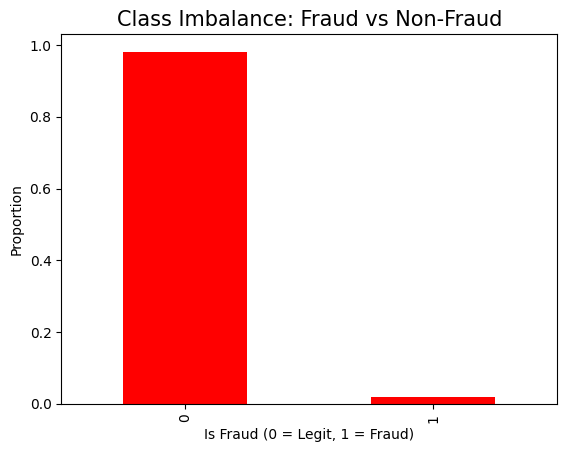

In [21]:
# Class Imbalance
nova_pay['is_fraud'].value_counts(normalize=True).plot(kind='bar', color = 'red')
plt.title("Class Imbalance: Fraud vs Non-Fraud", fontsize = 15, color = 'black')
plt.xlabel("Is Fraud (0 = Legit, 1 = Fraud)", fontsize = 10, color = 'black')
plt.ylabel("Proportion", fontsize = 10, color = 'black')
plt.show()

The class distribution reveals a significant imbalance between legitimate transactions and fraudulent transactions. The vast number of transactions are non-fraudulent, while only a small fraction are labeled as fraud. This imbalance is consistent with real-world payment systems, where fraudulent activity is relatively rare compared to the volume of legitimate transactions.
Despite their low frequency, fraudulent transactions pose a disproportionately high financial and reputational risk, making their detection critical.

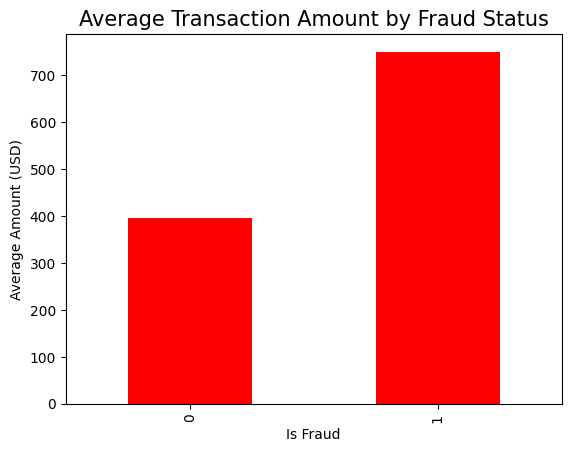

In [22]:
#Average Fraudulent Vs Non Fradulent Transaction Amount
nova_pay.groupby('is_fraud')['amount_usd'].mean().plot(kind='bar', color = 'red')
plt.title("Average Transaction Amount by Fraud Status",fontsize = 15, color = 'black')
plt.xlabel("Is Fraud",fontsize = 10, color = 'black')
plt.ylabel("Average Amount (USD)",fontsize = 10, color = 'black')
plt.show()

The results show that fraudulent transactions have a significantly higher average amount than non-fraudulent ones. While legitimate transactions cluster around a lower average value, fraudulent transactions tend to involve larger monetary amounts. This chart suggests that fraudsters often target high-value transactions to maximize financial gain within a short time window. As a result, transaction amount becomes an important risk indicator, especially when combined with other behavioral features.

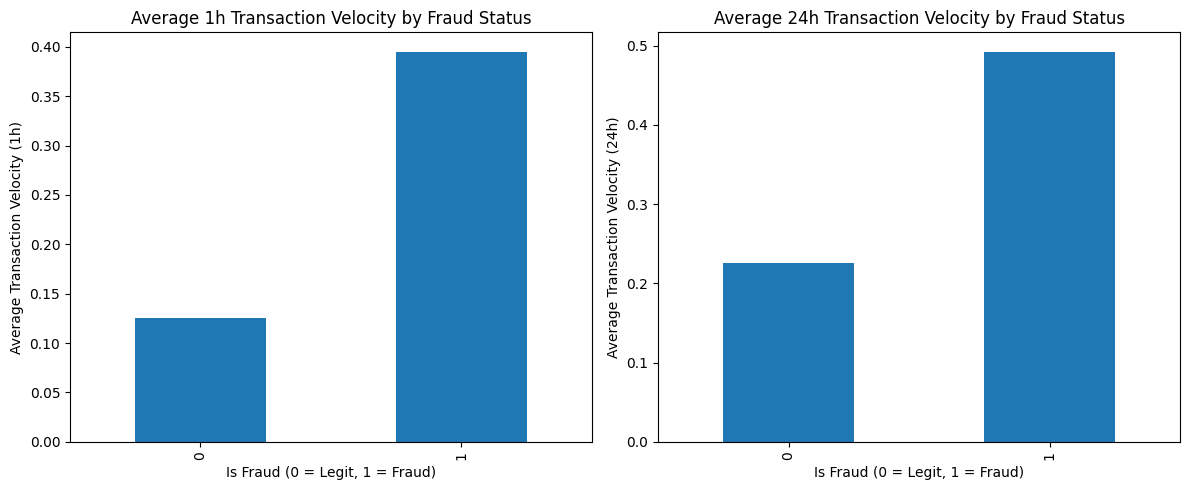

In [24]:
#Average velocity comparison
#1-hour transaction velocity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
nova_pay.groupby('is_fraud')['txn_velocity_1h'].mean().plot(kind='bar', ax=axes[0])
axes[0].set_title("Average 1h Transaction Velocity by Fraud Status")
axes[0].set_xlabel("Is Fraud (0 = Legit, 1 = Fraud)")
axes[0].set_ylabel("Average Transaction Velocity (1h)")

#24-hour transaction velocity
nova_pay.groupby('is_fraud')['txn_velocity_24h'].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title("Average 24h Transaction Velocity by Fraud Status")
axes[1].set_xlabel("Is Fraud (0 = Legit, 1 = Fraud)")
axes[1].set_ylabel("Average Transaction Velocity (24h)")

plt.tight_layout()
plt.show()

This chart indicates that, within a one-hour window, fraudulent transactions occur at approximately three times the rate of legitimate transactions. This pattern suggests rapid bursts of activity, which is characteristic of fraud attempts where attackers try to maximize impact before detection.
Over a 24-hour period, fraudulent transactions still show significantly higher activity, occurring at roughly double the rate of legitimate transactions. This implies that fraud is not always a single isolated event but often involves repeated attempts over time.

Transaction velocity is a strong behavioral indicator of fraud, with fraudulent transactions consistently exhibiting higher activity levels in both short and extended timeframes. The fact that this pattern persists across different windows strengthens its predictive value.

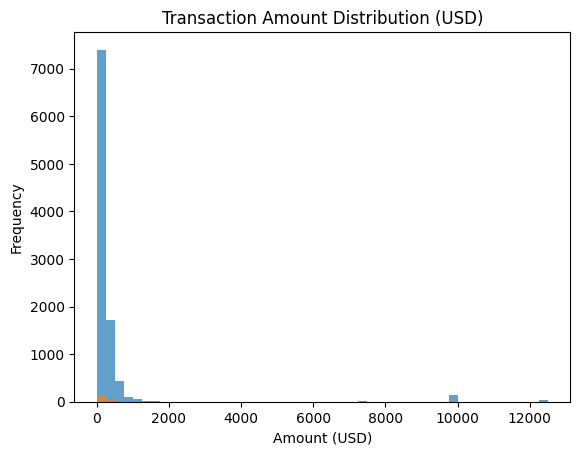

In [25]:
#Transaction Amount Distribution (Fraud vs Non-Fraud)
plt.figure()
nova_pay[nova_pay['is_fraud'] == 0]['amount_usd'].plot(kind='hist', bins=50, alpha=0.7,label='Legitimate (is_fraud = 0)')
nova_pay[nova_pay['is_fraud'] == 1]['amount_usd'].plot(kind='hist', bins=50, alpha=0.7, label='Fraud (is_fraud = 1')
plt.title('Transaction Amount Distribution (USD)')
plt.xlabel('Amount (USD)')
plt.ylabel('Frequency')
plt.show()

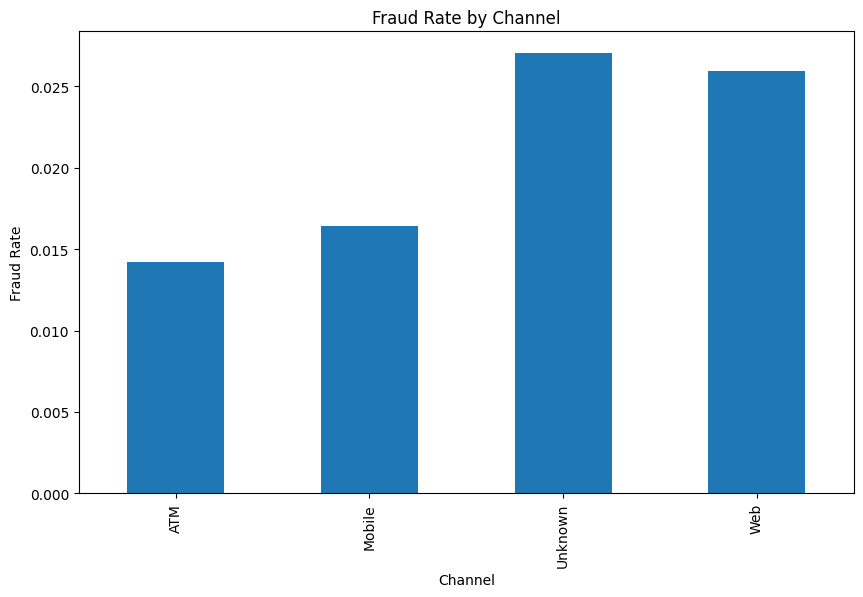

In [26]:
#Fraud Rate by Channel
plt.figure(figsize = (10,6))
nova_pay.groupby('channel')['is_fraud'].mean().plot(kind='bar')
plt.title('Fraud Rate by Channel')
plt.xlabel('Channel')
plt.ylabel('Fraud Rate')
plt.show()

The chart compares fraud rates across four transaction channels: ATM, Mobile, Web, and Unknown.

Unknown transactions have the highest fraud rate, indicating greater risk where the transaction source is not known.

Web transactions also show a high fraud rate, slightly below Unknown, suggesting online channels are more vulnerable to fraud.

Mobile transactions have a moderate fraud rate, higher than ATM but significantly lower than Web and Unknown.

ATM transactions record the lowest fraud rate, making them the most secure channel among those analyzed.

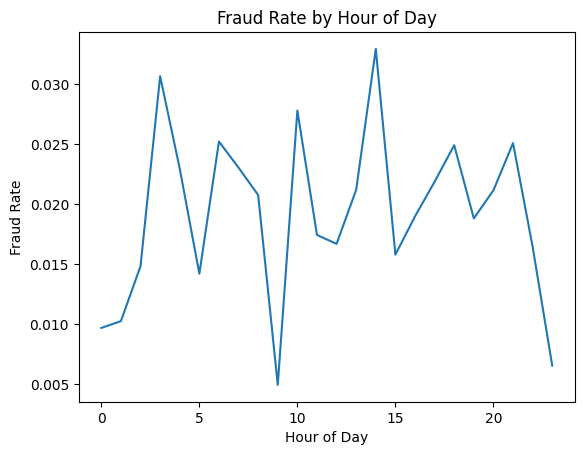

In [27]:
#Fraud Rate by Hour of Day
plt.figure()
nova_pay.groupby('hour')['is_fraud'].mean().plot()
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.show()

This chart shows how the fraud rate varies across different hours of the day (0–23).

**Key observations:**

Fraud activity is not evenly distributed throughout the day; it fluctuates significantly by hour.

Early morning hours (around 2–4 AM) show a noticeable spike in fraud rates, suggesting increased fraudulent activity when customer monitoring and user alertness may be lower.

Late morning to early afternoon (around 10 AM–2 PM) also experiences elevated fraud rates, with the peak occurring around mid-afternoon.

Lower fraud rates are observed during some early morning and late-night hours, particularly around 9 AM and close to midnight.

**Interpretation**

Fraud tends to increase during off-peak hours due to weaker oversight and during busy daytime periods because high transaction volumes make detection more difficult.

<Figure size 640x480 with 0 Axes>

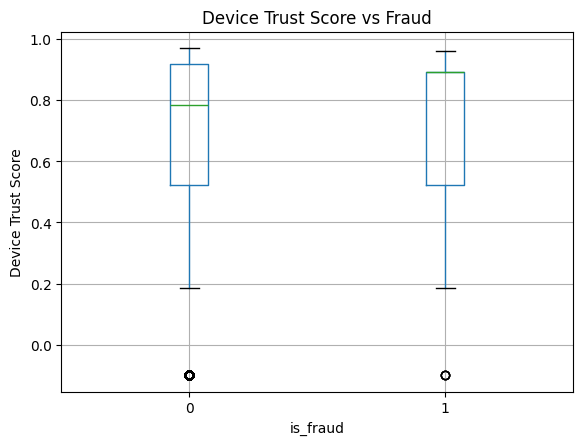

In [29]:
#Device Trust Score vs Fraud
plt.figure()
nova_pay.boxplot(column='device_trust_score', by='is_fraud')
plt.title('Device Trust Score vs Fraud')
plt.suptitle('')
plt.xlabel('is_fraud')
plt.ylabel('Device Trust Score')
plt.show()



*   Fraudulent transactions (is_fraud = 1) have a lower median device trust score than legitimate transactions.
*  The fraud group shows a wider spread and more extreme values, indicating inconsistent and riskier device behavior.
*   Legitimate transactions cluster around higher trust scores, suggesting repeat usage of known devices.

**Interpretation**

Fraudulent transactions exhibit lower median device trust scores and greater variability compared to legitimate transactions. This suggests that fraud is more likely to originate from unfamiliar or low-trust devices, highlighting device trust as an important fraud detection feature.”

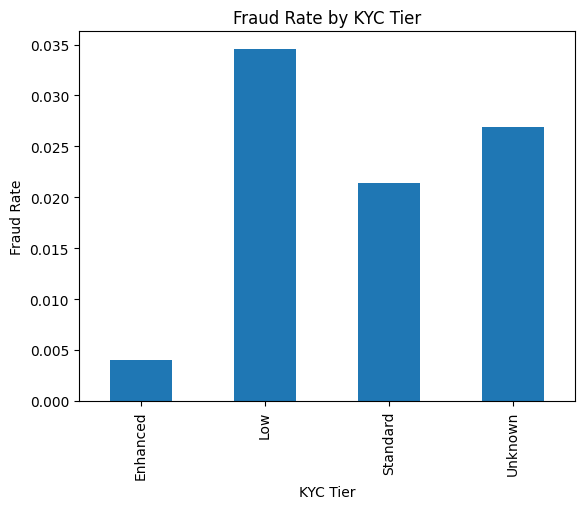

In [30]:
plt.figure()
pd.crosstab(nova_pay['kyc_tier'], nova_pay['is_fraud'], normalize='index')[1].plot(kind='bar')
plt.title('Fraud Rate by KYC Tier')
plt.xlabel('KYC Tier')
plt.ylabel('Fraud Rate')
plt.show()

This chart breaks down fraud rates based on the level of identity verification the user has undergone.

**Key Observations:**

**Low Tier has the highest risk rate:** The Low KYC tier exhibits the highest fraud rate, peaking at approximately 0.035 (3.5%). This suggests that accounts with minimal verification are the primary vehicle for fraudulent activity.

**"Enhanced" Tier is Safest**: The Enhanced tier has a negligible fraud rate (below 0.005 or 0.5%). This indicates that rigorous identity checks (likely involving biometric or government ID verification) are highly effective deterrents.

**"Unknown":** The Unknown category has a high fraud rate (~2.7%), nearly as high as the Low tier. This suggests that missing data is, in itself, a risk factor.

**"Standard" is Moderate:** The Standard tier sits in the middle (~2.1%), suggesting it filters out some opportunistic fraud but is still vulnerable to sophisticated actors.

**Interpretation:**

There is a clear inverse correlation between verification strictness and fraud. As friction (verification) increases, fraud decreases.

Fraudsters prefer the path of least resistance, targeting Low tier accounts where they can likely onboard quickly without leaving a paper trail.

Synthesis & Strategic Recommendations
Combining insights from both charts provides a clear profile of the "High-Risk Transaction"

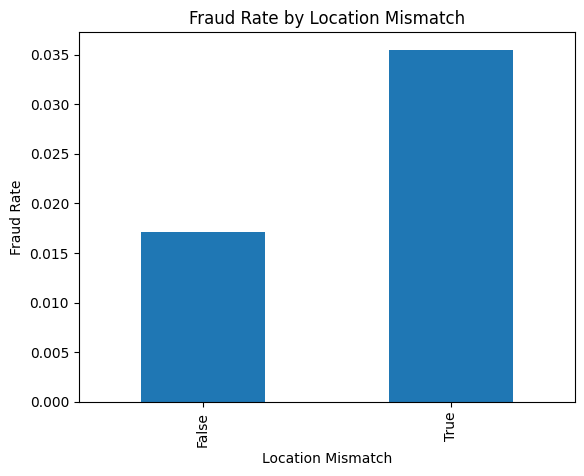

In [31]:
plt.figure()
pd.crosstab(nova_pay['location_mismatch'], nova_pay['is_fraud'], normalize='index')[1].plot(kind='bar')
plt.title('Fraud Rate by Location Mismatch')
plt.xlabel('Location Mismatch')
plt.ylabel('Fraud Rate')
plt.show()


This chart analyzes the relationship between geographic consistency (whether the transaction location matches the user's registered location) and fraud probability.

**Key Observations:**

High Risk with Mismatch: The fraud rate for transactions where Location Mismatch == True is approximately 0.035 (3.5%).

Lower Risk with Match: The fraud rate where Location Mismatch == False is significantly lower, at approximately 0.017 (1.7%).

The Multiplier Effect: A location mismatch doubles the risk of fraud.

**Interpretation:**

Geolocation data is a powerful predictive feature. When a transaction originates from a location different from the user's home or usual activity zone, it is a strong signal of potential account compromise or stolen credentials.

However, the non-zero fraud rate for "False" (matched locations) suggests that fraudsters also operate locally or use tools (like VPNs) to spoof locations, meaning location alone cannot be the sole determinant for blocking transactions.

In [32]:
nova_pay.to_csv('Cleaned_nova_pay_data.csv', index = False)

## **Conclusion**

This exploratory data analysis revealed clear patterns and anomalies associated with fraudulent transactions. Fraud cases were not evenly distributed across the dataset but were concentrated around specific transaction characteristics such as transaction amount, time patterns, and selected behavioral or account features. The strong class imbalance between fraudulent and non-fraudulent transactions highlights the challenge of fraud detection and the risk of biased model performance if not properly addressed.

Several variables showed significant differences between fraud and non-fraud transactions, suggesting they are important predictors for fraud detection models. Correlation analysis and feature distributions further indicate that fraud is often driven by a combination of factors rather than a single indicator. Overall, the EDA confirms that the dataset contains meaningful signals that can be leveraged to build effective fraud detection systems when combined with appropriate preprocessing and modeling techniques.